In [ ]:
#default_exp vision.augment
#default_cls_lvl 3

# Data augmentation in computer vision

> Transforms to apply data augmentation in Computer Vision

In [ ]:
#export
from fastai2.data.all import *
from fastai2.vision.core import *
from fastai2.vision.data import *

In [ ]:
from nbdev.showdoc import *

In [ ]:
# export
from torch import stack, zeros_like as t0, ones_like as t1
from torch.distributions.bernoulli import Bernoulli

In [ ]:
img = PILImage(PILImage.create(TEST_IMAGE).resize((600,400)))

## RandTransform-

In [ ]:
# export
class RandTransform(Transform):
    "A transform that before_call its state at each `__call__`"
    do,nm,supports,split_idx = True,None,[],0
    def __init__(self, p=1., nm=None, before_call=None, **kwargs):
        super().__init__(**kwargs)
        self.p,self.before_call = p,ifnone(before_call,self.before_call)

    def before_call(self, b, split_idx):
        "before_call the state for input `b`"
        self.do = self.p==1. or random.random() < self.p

    def __call__(self, b, split_idx=None, **kwargs):
        self.before_call(b, split_idx=split_idx)
        return super().__call__(b, split_idx=split_idx, **kwargs) if self.do else b

As for all `Transform` you can pass `encodes` and `decodes` at init or subclass and implement them. You can do the same for the `before_call` method that is called at each `__call__`. Note that to have a consistent state for inputs and targets, a `RandTransform` must be applied at the tuple level. 

By default the before_call behavior is to execute the transform with probability `p` (if subclassing and wanting to tweak that behavior, the attribute `self.do`, if it exists, is looked for to decide if the transform is executed or not).

> Note: A <code>RandTransform</code> is only applied to the training set by default, so you have to pass `split_idx=0` if you are calling it directly and not through a <code>Datasets</code>. That behavior can be changed by setting the attr `split_idx` of the transform to `None`.

In [ ]:
show_doc(RandTransform.before_call)

<h4 id="RandTransform.before_call" class="doc_header"><code>RandTransform.before_call</code><a href="__main__.py#L9" class="source_link" style="float:right">[source]</a></h4>

> <code>RandTransform.before_call</code>(**`b`**, **`split_idx`**)

before_call the state for input `b`

In [ ]:
def _add1(x): return x+1
dumb_tfm = RandTransform(enc=_add1, p=0.5)
start,d1,d2 = 2,False,False
for _ in range(40):
    t = dumb_tfm(start, split_idx=0)
    if dumb_tfm.do: test_eq(t, start+1); d1=True
    else:           test_eq(t, start)  ; d2=True
assert d1 and d2

## Item transforms

In [ ]:
# export
def _neg_axis(x, axis):
    x[...,axis] = -x[...,axis]
    return x

TensorTypes = (TensorImage,TensorMask,TensorPoint,TensorBBox)

In [ ]:
# export
@patch
def flip_lr(x:Image.Image): return x.transpose(Image.FLIP_LEFT_RIGHT)
@patch
def flip_lr(x:TensorImageBase): return x.flip(-1)
@patch
def flip_lr(x:TensorPoint): return TensorPoint(_neg_axis(x.clone(), 0))
@patch
def flip_lr(x:TensorBBox):  return TensorBBox(TensorPoint(x.view(-1,2)).flip_lr().view(-1,4))

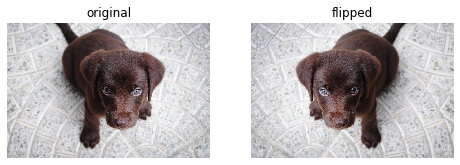

In [ ]:
_,axs = subplots(1,2)
show_image(img, ctx=axs[0], title='original')
show_image(img.flip_lr(), ctx=axs[1], title='flipped');

In [ ]:
#hide
def _pnt2tensor(pnts, sz):
    t = torch.zeros(*sz)
    for p in pnts: t[p[1],p[0]] = 1.
    return t

t = _pnt2tensor([[1,0], [2,1]], (3,3))
x = PILImage.create(t)
y = x.flip_lr()
test_eq(tensor(array(y)), _pnt2tensor([[1,0], [0,1]], (3,3)))

pnts = TensorPoint(tensor([[1.,0], [2,1]]) -1)
test_eq(pnts.flip_lr(), tensor([[1.,0], [0,1]]) -1)

bbox = TensorBBox((tensor([[1.,0., 2.,1]]) -1))
test_eq(bbox.flip_lr(), tensor([[1.,0., 0.,1]]) -1)

In [ ]:
# export
class FlipItem(RandTransform):
    "Randomly flip with probability `p`"
    def __init__(self, p=0.5): super().__init__(p=p)
    def encodes(self, x:(Image.Image,*TensorTypes)): return x.flip_lr()

In [ ]:
tflip = FlipItem(p=1.)
test_eq(tflip(bbox,split_idx=0), tensor([[1.,0., 0.,1]]) -1)

In [ ]:
# export
@patch
def dihedral(x:PILImage, k): return x if k==0 else x.transpose(k-1)
@patch
def dihedral(x:TensorImage, k):
        if k in [1,3,4,7]: x = x.flip(-1)
        if k in [2,4,5,7]: x = x.flip(-2)
        if k in [3,5,6,7]: x = x.transpose(-1,-2)
        return x
@patch
def dihedral(x:TensorPoint, k):
        if k in [1,3,4,7]: x = _neg_axis(x, 0)
        if k in [2,4,5,7]: x = _neg_axis(x, 1)
        if k in [3,5,6,7]: x = x.flip(1)
        return x
@patch
def dihedral(x:TensorBBox, k):
        pnts = TensorPoint(x.view(-1,2)).dihedral(k).view(-1,2,2)
        tl,br = pnts.min(dim=1)[0],pnts.max(dim=1)[0]
        return TensorBBox(torch.cat([tl, br], dim=1), img_size=x.get_meta('img_size'))

By default each of the 8 dihedral transformations (including noop) have the same probability of being picked when the transform is applied. You can customize this behavior by passing your own `draw` function. To force a specific flip, you can also pass an integer between 0 and 7. 

In [ ]:
# export
class DihedralItem(RandTransform):
    "Randomly flip with probability `p`"
    def __init__(self, p=0.5): super().__init__(p=p)

    def before_call(self, b, split_idx):
        super().before_call(b, split_idx)
        self.k = random.randint(0,7)

    def encodes(self, x:(Image.Image,*TensorTypes)): return x.dihedral(self.k)

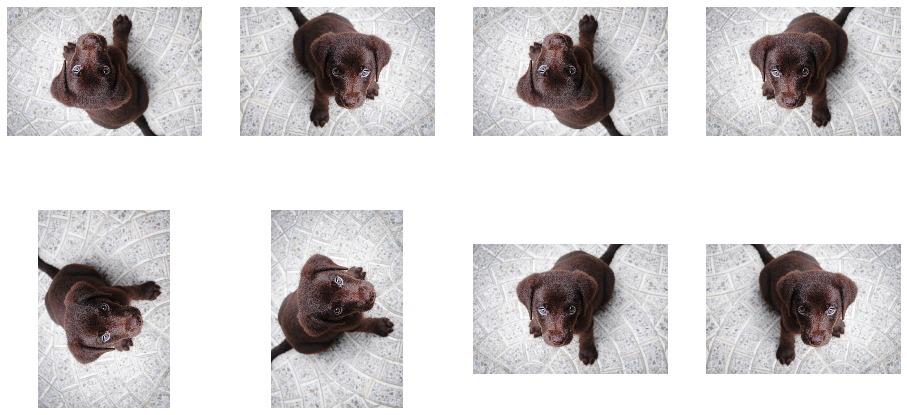

In [ ]:
_,axs = subplots(2, 4)
for ax in axs.flatten():
    show_image(DihedralItem(p=1.)(img, split_idx=0), ctx=ax)

In [ ]:
#hide
t = _pnt2tensor([[1,0], [2,1]], (3,3))
x = PILImage.create(t)
for i in range(8):
    y = x.dihedral(i)
    res = tensor(array(y))
    pnts = TensorPoint(tensor([[1.,0.], [2,1]]) -1)
    a,b = pnts.dihedral(i), res.nonzero().flip(1).float()-1
    assert equals(a,b) or equals(a,b.flip(0))

## Resize with crop, pad or squish

In [ ]:
# export
from torchvision.transforms.functional import pad as tvpad

In [ ]:
# export
mk_class('PadMode', **{o:o.lower() for o in ['Zeros', 'Border', 'Reflection']},
         doc="All possible padding mode as attributes to get tab-completion and typo-proofing")

In [ ]:
#export
_all_ = ['PadMode']

In [ ]:
show_doc(PadMode, title_level=3)

<h3 id="PadMode" class="doc_header"><code>class</code> <code>PadMode</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>PadMode</code>(**\*`args`**, **\*\*`kwargs`**)

All possible padding mode as attributes to get tab-completion and typo-proofing

In [ ]:
# export
_pad_modes = {'zeros': 'constant', 'border': 'edge', 'reflection': 'reflect'}

@patch
def _do_crop_pad(x:Image.Image, sz, tl, orig_sz,
                 pad_mode=PadMode.Zeros, resize_mode=Image.BILINEAR, resize_to=None):
    if any(tl.ge(0)):
        # At least one dim is inside the image, so needs to be cropped
        c = tl.max(0)
        x = x.crop((*c, *c.add(sz).min(orig_sz)))
    if any(tl.lt(0)):
        # At least one dim is outside the image, so needs to be padded
        p = (-tl).max(0)
        f = (sz-orig_sz-p).max(0)
        x = tvpad(x, (*p, *f), padding_mode=_pad_modes[pad_mode])
    if resize_to is not None: x = x.resize(resize_to, resize_mode)
    return x

@patch
def _do_crop_pad(x:TensorPoint, sz, tl, orig_sz, pad_mode=PadMode.Zeros, resize_to=None, **kwargs):
    #assert pad_mode==PadMode.Zeros,"Only zero padding is supported for `TensorPoint` and `TensorBBox`"
    orig_sz,sz,tl = map(FloatTensor, (orig_sz,sz,tl))
    return TensorPoint((x+1)*orig_sz/sz - tl*2/sz - 1, sz=sz if resize_to is None else resize_to)

@patch
def _do_crop_pad(x:TensorBBox, sz, tl, orig_sz, pad_mode=PadMode.Zeros, resize_to=None, **kwargs):
    bbox = TensorPoint._do_crop_pad(x.view(-1,2), sz, tl, orig_sz, pad_mode, resize_to).view(-1,4)
    return TensorBBox(bbox, img_size=x.get_meta('img_size'))

@patch
def crop_pad(x:(TensorBBox,TensorPoint,Image.Image),
             sz, tl=None, orig_sz=None, pad_mode=PadMode.Zeros, resize_mode=Image.BILINEAR, resize_to=None):
    if isinstance(sz,int): sz = (sz,sz)
    orig_sz = Tuple(x.size if orig_sz is None else orig_sz)
    sz,tl = Tuple(sz),Tuple(((x.size-sz)//2) if tl is None else tl)
    return x._do_crop_pad(sz, tl, orig_sz=orig_sz, pad_mode=pad_mode, resize_mode=resize_mode, resize_to=resize_to)

In [ ]:
# export
def _process_sz(size):
    if isinstance(size,int): size=(size,size)
    return Tuple(size[1],size[0])

def _get_sz(x):
    if isinstance(x, tuple): x = x[0]
    if not isinstance(x, Tensor): return Tuple(x.size)
    return Tuple(x.get_meta('img_size', (x.shape[-1], x.shape[-2])))

In [ ]:
# export
@delegates()
class CropPad(Transform):
    "Center crop or pad an image to `size`"
    order=0
    def __init__(self, size, pad_mode=PadMode.Zeros, **kwargs):
        super().__init__(**kwargs)
        self.size,self.pad_mode = _process_sz(size),pad_mode

    def encodes(self, x:(Image.Image,TensorBBox,TensorPoint)):
        orig_sz = _get_sz(x)
        tl = (orig_sz-self.size)//2
        return x.crop_pad(self.size, tl, orig_sz=orig_sz, pad_mode=self.pad_mode)

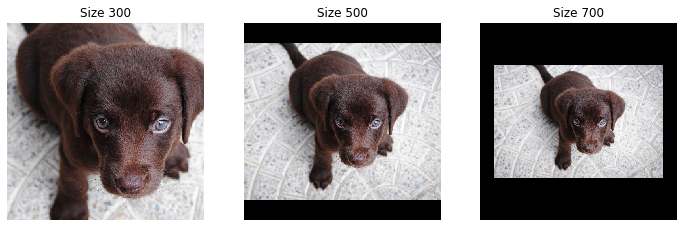

In [ ]:
_,axs = plt.subplots(1,3,figsize=(12,4))
for ax,sz in zip(axs.flatten(), [300, 500, 700]):
    show_image(img.crop_pad(sz), ctx=ax, title=f'Size {sz}');

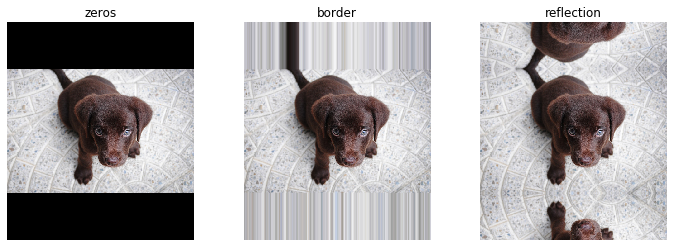

In [ ]:
_,axs = plt.subplots(1,3,figsize=(12,4))
for ax,mode in zip(axs.flatten(), [PadMode.Zeros, PadMode.Border, PadMode.Reflection]):
    show_image(img.crop_pad((600,700), pad_mode=mode), ctx=ax, title=mode);

In [ ]:
#hide
ta = torch.empty(16,16).uniform_(0,1)
tb = torch.empty(20,20).uniform_(0,1)
x1 = PILImage.create(ta)
x2 = PILImage.create(tb)
crop = CropPad(10)
crop.as_item=False
y1,y2 = crop((x1,x2))
test_eq(y1.size, (10,10))
test_eq(y2.size, (10,10))
test_eq(tensor(array(y1)), ta[3:13,3:13])
test_eq(tensor(array(y2)), tb[5:15,5:15])

In [ ]:
#hide
t = torch.empty(20,16).uniform_(0,1)
x = PILImage.create(t)
crop = CropPad(10)
y = crop(x)
test_eq(y.size, (10,10))
test_eq(tensor(array(y)), t[5:15,3:13])

crop.as_item=False
pts = TensorPoint(torch.tensor([[-1,-1], [-0.5,-0.5], [0.,0.]]), img_size=(16,20))
y,p1 = crop((x,pts))
test_eq(p1, torch.tensor([[-1.6, -2], [-0.8,-1], [0,0]]))

In [ ]:
#hide
#Padding test
t = torch.empty(10,8).uniform_(0,1)
x = PILImage.create(t)
crop = CropPad(12)
y = crop(x)
test_eq(y.size, (12,12))
test_eq(tensor(array(y))[1:11,2:10], t)

crop.as_item=False
pts = TensorPoint(torch.tensor([[-1,-1], [-0.5,-0.5], [0.,0.]]), img_size=(8,10))
y,p1 = crop((x,pts))
test_close(p1, torch.tensor([[-2/3, -5/6], [-1/3,-5/12], [0,0]]))

## RandomCrop -

In [ ]:
# export
@delegates()
class RandomCrop(RandTransform):
    "Randomly crop an image to `size`"
    split_idx = None
    order = 1
    def __init__(self, size, **kwargs):
        super().__init__(**kwargs)
        self.size = _process_sz(size)

    def before_call(self, b, split_idx):
        self.orig_sz = _get_sz(b)
        if split_idx: self.tl = (self.orig_sz-self.size)//2
        else: self.tl = Tuple(random.randint(0,self.orig_sz[0]-self.size[0]), random.randint(0,self.orig_sz[1]-self.size[1]))

    def encodes(self, x:(Image.Image,TensorBBox,TensorPoint)):
        return x.crop_pad(self.size, self.tl, orig_sz=self.orig_sz)

In [ ]:
# export
class OldRandomCrop(CropPad):
    "Randomly crop an image to `size`"
    def before_call(self, b, split_idx):
        super().before_call(b, split_idx)
        w,h = self.orig_sz
        if not split_idx: self.tl = (random.randint(0,w-self.cp_size[0]), random.randint(0,h-self.cp_size[1]))

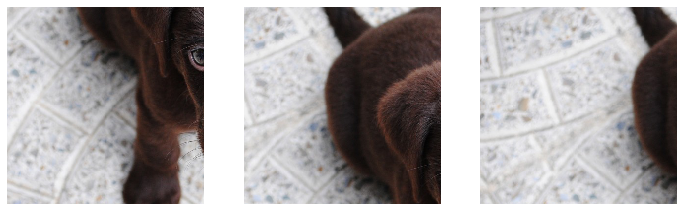

In [ ]:
_,axs = plt.subplots(1,3,figsize=(12,4))
f = RandomCrop(200)
for ax in axs: show_image(f(img), ctx=ax);

On the validation set, we take a center crop.

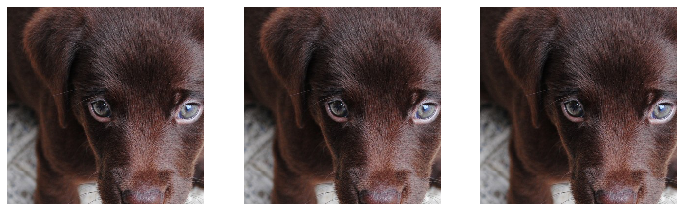

In [ ]:
_,axs = plt.subplots(1,3,figsize=(12,4))
for ax in axs: show_image(f(img, split_idx=1), ctx=ax);

In [ ]:
#hide
t = torch.empty(20,16).uniform_(0,1)
x = PILImage.create(t)
crop = RandomCrop(10)
y = crop(x, split_idx=0)
test_eq(y.size, (10,10))
test_eq(tensor(array(y)), t[crop.tl[1]:crop.tl[1]+10,crop.tl[0]:crop.tl[0]+10])

crop.as_item=False
pts = TensorPoint(torch.tensor([[-1,-1], [-0.5,-0.5], [0.,0.]]))
y,p1 = crop((x,pts), split_idx=0)
test_eq(p1, (pts+1) * tensor([1.6,2.]) - tensor(crop.tl).float()/5 - 1)

In [ ]:
#hide
#test it's a center crop on the validation set
y = crop(x, split_idx=1)
test_eq(y.size, (10,10))
test_eq(tensor(array(y)), t[5:15,3:13])

In [ ]:
# export
mk_class('ResizeMethod', **{o:o.lower() for o in ['Squish', 'Crop', 'Pad']},
         doc="All possible resize method as attributes to get tab-completion and typo-proofing")

In [ ]:
#export
_all_ = ['ResizeMethod']

In [ ]:
show_doc(ResizeMethod, title_level=3)

<h3 id="ResizeMethod" class="doc_header"><code>class</code> <code>ResizeMethod</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>ResizeMethod</code>(**\*`args`**, **\*\*`kwargs`**)

All possible resize method as attributes to get tab-completion and typo-proofing

In [ ]:
test_eq(ResizeMethod.Squish, 'squish')

## Resize -

In [ ]:
# export
@delegates()
class Resize(RandTransform):
    split_idx = None
    mode,mode_mask,order,final_size = Image.BILINEAR,Image.NEAREST,1,None
    "Resize image to `size` using `method`"
    def __init__(self, size, method=ResizeMethod.Crop, pad_mode=PadMode.Reflection,
                 resamples=(Image.BILINEAR, Image.NEAREST), **kwargs):
        super().__init__(**kwargs)
        self.size,self.pad_mode,self.method = _process_sz(size),pad_mode,method
        self.mode,self.mode_mask = resamples

    def before_call(self, b, split_idx):
        if self.method==ResizeMethod.Squish: return
        self.pcts = (0.5,0.5) if split_idx else (random.random(),random.random())

    def encodes(self, x:(Image.Image,TensorBBox,TensorPoint)):
        orig_sz = _get_sz(x)
        self.final_size = self.size
        if self.method==ResizeMethod.Squish:
            return x.crop_pad(orig_sz, Tuple(0,0), orig_sz=orig_sz, pad_mode=self.pad_mode,
                   resize_mode=self.mode_mask if isinstance(x,PILMask) else self.mode, resize_to=self.size)

        w,h = orig_sz
        op = (operator.lt,operator.gt)[self.method==ResizeMethod.Pad]
        m = w/self.size[0] if op(w/self.size[0],h/self.size[1]) else h/self.size[1]
        cp_sz = (int(m*self.size[0]),int(m*self.size[1]))
        tl = Tuple(int(self.pcts[0]*(w-cp_sz[0])), int(self.pcts[1]*(h-cp_sz[1])))
        return x.crop_pad(cp_sz, tl, orig_sz=orig_sz, pad_mode=self.pad_mode,
                   resize_mode=self.mode_mask if isinstance(x,PILMask) else self.mode, resize_to=self.size)

`size` can be an integer (in which case images will be resized to a square) or a tuple. Depending on the `method`:
- we squish any rectangle to `size`
- we resize so that the shorter dimension is a match an use padding with `pad_mode` 
- we resize so that the larger dimension is match and crop (randomly on the training set, center crop for the validation set)

When doing the resize, we use `resamples[0]` for images and `resamples[1]` for segmentation masks.

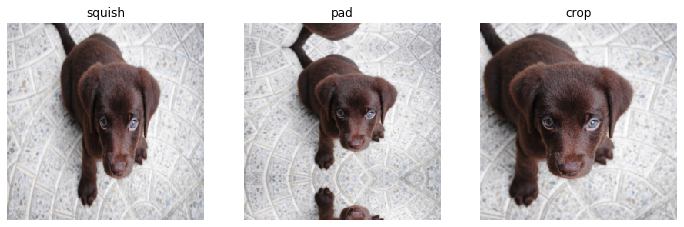

In [ ]:
_,axs = plt.subplots(1,3,figsize=(12,4))
for ax,method in zip(axs.flatten(), [ResizeMethod.Squish, ResizeMethod.Pad, ResizeMethod.Crop]):
    rsz = Resize(256, method=method)
    show_image(rsz(img, split_idx=0), ctx=ax, title=method);

On the validation set, the crop is always a center crop (on the dimension that's cropped).

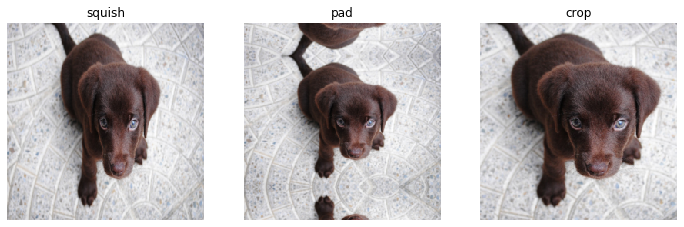

In [ ]:
_,axs = plt.subplots(1,3,figsize=(12,4))
for ax,method in zip(axs.flatten(), [ResizeMethod.Squish, ResizeMethod.Pad, ResizeMethod.Crop]):
    rsz = Resize(256, method=method)
    show_image(rsz(img, split_idx=1), ctx=ax, title=method);

In [ ]:
#hide
t = torch.empty(20,16).uniform_(0,1)
x = PILImage.create(t)
rsz = Resize(10)
y = rsz(x, split_idx=0)
test_eq(y.size, (10,10))

y = rsz(x, split_idx=1)
test_eq(y.size, (10,10))

## RandomResizedCrop -

In [ ]:
# export
@delegates()
class RandomResizedCrop(RandTransform):
    "Picks a random scaled crop of an image and resize it to `size`"
    split_idx = None
    def __init__(self, size, min_scale=0.08, ratio=(3/4, 4/3), resamples=(Image.BILINEAR, Image.NEAREST),
                 val_xtra=0.14, **kwargs):
        super().__init__(**kwargs)
        self.size = _process_sz(size)
        store_attr(self, 'min_scale,ratio,val_xtra')
        self.mode,self.mode_mask = resamples

    def before_call(self, b, split_idx):
        w,h = self.orig_sz = _get_sz(b)
        if split_idx:
            xtra = math.ceil(max(*self.size[:2])*self.val_xtra/8)*8
            self.final_size = (self.size[0]+xtra, self.size[1]+xtra)
            self.tl,self.cp_size = (0,0),self.orig_sz
            return
        self.final_size = self.size
        for attempt in range(10):
            area = random.uniform(self.min_scale,1.) * w * h
            ratio = math.exp(random.uniform(math.log(self.ratio[0]), math.log(self.ratio[1])))
            nw = int(round(math.sqrt(area * ratio)))
            nh = int(round(math.sqrt(area / ratio)))
            if nw <= w and nh <= h:
                self.cp_size = (nw,nh)
                self.tl = random.randint(0,w-nw), random.randint(0,h - nh)
                return
        if   w/h < self.ratio[0]: self.cp_size = (w, int(w/self.ratio[0]))
        elif w/h > self.ratio[1]: self.cp_size = (int(h*self.ratio[1]), h)
        else:                     self.cp_size = (w, h)
        self.tl = ((w-self.cp_size[0])//2, (h-self.cp_size[1])//2)

    def encodes(self, x:(Image.Image,TensorBBox,TensorPoint)):
        res = x.crop_pad(self.cp_size, self.tl, orig_sz=self.orig_sz,
            resize_mode=self.mode_mask if isinstance(x,PILMask) else self.mode, resize_to=self.final_size)
        if self.final_size != self.size: res = res.crop_pad(self.size) #Validation set: one final center crop
        return res

The crop picked as a random scale in range `(min_scale,1)` and `ratio` in the range passed, then the resize is done with `resamples[0]` for images and `resamples[1]` for segmentation masks. On the validation set, we center crop the image if it's ratio isn't in the range (to the minmum or maximum value) then resize.

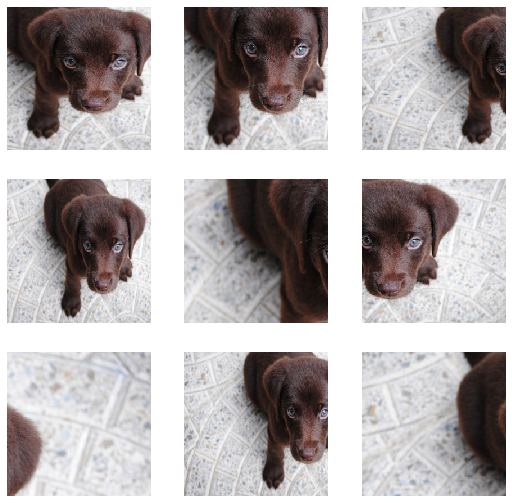

In [ ]:
crop = RandomResizedCrop(256)
_,axs = plt.subplots(3,3,figsize=(9,9))
for ax in axs.flatten():
    cropped = crop(img)
    show_image(cropped, ctx=ax);

Squish is used on the validation set, removing `val_xtra` proportion of each side first.

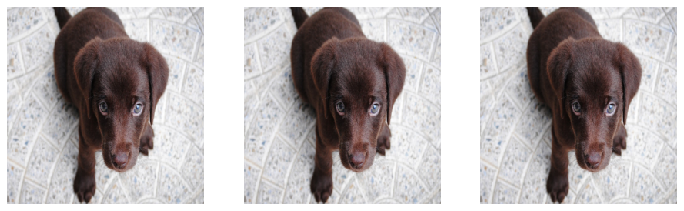

In [ ]:
_,axs = subplots(1,3)
for ax in axs.flatten(): show_image(crop(img, split_idx=1), ctx=ax);

In [ ]:
test_eq(cropped.shape, [256,256])

## RatioResize -

In [ ]:
#export
class RatioResize(Transform):
    'Resizes the biggest dimension of an image to `max_sz` maintaining the aspect ratio'
    def __init__(self, max_sz, resamples=(Image.BILINEAR, Image.NEAREST)):
        self.max_sz,self.resamples = max_sz,resamples

    def encodes(self, x:(Image.Image,TensorBBox,TensorPoint)):
        w,h = x.size
        if w >= h: nw,nh = self.max_sz,h*self.max_sz/w
        else:      nw,nh = w*self.max_sz/h,self.max_sz
        return Resize(size=(int(nh),int(nw)), resamples=self.resamples)(x)

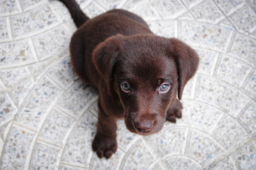

In [ ]:
RatioResize(256)(img)

In [ ]:
test_eq(RatioResize(256)(img).size[0], 256)
test_eq(RatioResize(256)(img.dihedral(3)).size[1], 256)

## Affine and coord tfm on the GPU

In [ ]:
timg = TensorImage(array(img)).permute(2,0,1).float()/255.
def _batch_ex(bs): return TensorImage(timg[None].expand(bs, *timg.shape).clone())

In [ ]:
#export
def _init_mat(x):
    mat = torch.eye(3, device=x.device).float()
    return mat.unsqueeze(0).expand(x.size(0), 3, 3).contiguous()

### AffineCoordTfm -

In [ ]:
#export
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")
def _grid_sample(x, coords, mode='bilinear', padding_mode='reflection'):
    "Resample pixels in `coords` from `x` by `mode`, with `padding_mode` in ('reflection','border','zeros')."
    #coords = coords.permute(0, 3, 1, 2).contiguous().permute(0, 2, 3, 1) # optimize layout for grid_sample
    if mode=='bilinear': # hack to get smoother downwards resampling
        mn,mx = coords.min(),coords.max()
        # max amount we're affine zooming by (>1 means zooming in)
        z = 1/(mx-mn).item()*2
        # amount we're resizing by, with 100% extra margin
        d = min(x.shape[-2]/coords.shape[-2], x.shape[-1]/coords.shape[-1])/2
        # If we're resizing up by >200%, and we're zooming less than that, interpolate first
        if d>1 and d>z:
            x = F.interpolate(x, scale_factor=1/d, mode='area')
    with warnings.catch_warnings():
        #To avoid the warning that come from grid_sample.
        warnings.simplefilter("ignore")
        return F.grid_sample(x, coords, mode=mode, padding_mode=padding_mode)

In [ ]:
#export
@patch
def affine_coord(x: TensorImage, mat=None, coord_tfm=None, sz=None, mode='bilinear', pad_mode=PadMode.Reflection):
    if mat is None and coord_tfm is None and sz is None: return x
    size = tuple(x.shape[-2:]) if sz is None else (sz,sz) if isinstance(sz,int) else tuple(sz)
    if mat is None: mat = _init_mat(x)[:,:2]
    coords = F.affine_grid(mat, x.shape[:2] + size)
    if coord_tfm is not None: coords = coord_tfm(coords)
    return TensorImage(_grid_sample(x, coords, mode=mode, padding_mode=pad_mode))

@patch
def affine_coord(x: TensorMask, mat=None, coord_tfm=None, sz=None, mode='nearest', pad_mode=PadMode.Reflection):
    add_dim = (x.ndim==3)
    if add_dim: x = x[:,None]
    res = TensorImage.affine_coord(x.float(), mat, coord_tfm, sz, mode, pad_mode).long()
    if add_dim: res = res[:,0]
    return TensorMask(res)

@patch
def affine_coord(x: TensorPoint, mat=None, coord_tfm=None, sz=None, mode='nearest', pad_mode=PadMode.Zeros):
    #assert pad_mode==PadMode.Zeros, "Only zero padding is supported for `TensorPoint` and `TensorBBox`"
    if sz is None: sz = x.get_meta('img_size')
    if coord_tfm is not None: x = coord_tfm(x, invert=True)
    if mat is not None: x = (x - mat[:,:,2].unsqueeze(1)) @ torch.inverse(mat[:,:,:2].transpose(1,2))
    return TensorPoint(x, sz=sz)

@patch
def affine_coord(x: TensorBBox, mat=None, coord_tfm=None, sz=None, mode='nearest', pad_mode=PadMode.Zeros):
    if mat is None and coord_tfm is None: return x
    if sz is None: sz = x.get_meta('img_size')
    bs,n = x.shape[:2]
    pnts = stack([x[...,:2], stack([x[...,0],x[...,3]],dim=2),
                  stack([x[...,2],x[...,1]],dim=2), x[...,2:]], dim=2)
    pnts = TensorPoint(pnts.view(bs, 4*n, 2), img_size=sz).affine_coord(mat, coord_tfm, sz, mode, pad_mode)
    pnts = pnts.view(bs, n, 4, 2)
    tl,dr = pnts.min(dim=2)[0],pnts.max(dim=2)[0]
    return TensorBBox(torch.cat([tl, dr], dim=2), img_size=sz)

In [ ]:
#export
def _prepare_mat(x, mat):
    h,w = x.get_meta('img_size', x.shape[-2:])
    mat[:,0,1] *= h/w
    mat[:,1,0] *= w/h
    return mat[:,:2]

In [ ]:
# export
class AffineCoordTfm(RandTransform):
    "Combine and apply affine and coord transforms"
    order,split_idx = 30,None
    def __init__(self, aff_fs=None, coord_fs=None, size=None, mode='bilinear', pad_mode=PadMode.Reflection, mode_mask='nearest'):
        self.aff_fs,self.coord_fs = L(aff_fs),L(coord_fs)
        store_attr(self, 'size,mode,pad_mode,mode_mask')
        self.cp_size = None if size is None else (size,size) if isinstance(size, int) else tuple(size)

    def before_call(self, b, split_idx):
        if isinstance(b, tuple): b = b[0]
        self.split_idx = split_idx
        self.do,self.mat = True,self._get_affine_mat(b)
        for t in self.coord_fs: t.before_call(b)

    def compose(self, tfm):
        "Compose `self` with another `AffineCoordTfm` to only do the interpolation step once"
        self.aff_fs   += tfm.aff_fs
        self.coord_fs += tfm.coord_fs

    def _get_affine_mat(self, x):
        aff_m = _init_mat(x)
        if self.split_idx: return _prepare_mat(x, aff_m)
        ms = [f(x) for f in self.aff_fs]
        ms = [m for m in ms if m is not None]
        for m in ms: aff_m = aff_m @ m
        return _prepare_mat(x, aff_m)

    def _encode(self, x, mode, reverse=False):
        coord_func = None if len(self.coord_fs)==0 or self.split_idx else partial(compose_tfms, tfms=self.coord_fs, reverse=reverse)
        return x.affine_coord(self.mat, coord_func, sz=self.size, mode=mode, pad_mode=self.pad_mode)

    def encodes(self, x:TensorImage): return self._encode(x, self.mode)
    def encodes(self, x:TensorMask):  return self._encode(x, self.mode_mask)
    def encodes(self, x:(TensorPoint, TensorBBox)): return self._encode(x, self.mode, reverse=True)

Multipliy all the matrices returned by `aff_fs` before doing the corresponding affine transformation on a basic grid corresponding to `size`, then applies all `coord_fs` on the resulting flow of coordinates before finally doing an interpolation with `mode` and `pad_mode`.

In [ ]:
show_doc(AffineCoordTfm.compose)

<h4 id="AffineCoordTfm.compose" class="doc_header"><code>AffineCoordTfm.compose</code><a href="__main__.py#L16" class="source_link" style="float:right">[source]</a></h4>

> <code>AffineCoordTfm.compose</code>(**`tfm`**)

Compose `self` with another [`AffineCoordTfm`](/vision.augment#AffineCoordTfm) to only do the interpolation step once

In [ ]:
#hide
#Test the reize is done both on the training and validation set
tfm = AffineCoordTfm(size=10)
t = TensorImage(torch.empty(2, 3, 20,16).uniform_(0,1))
for i in [0,1]:
    y = tfm(t, split_idx=i)
    test_eq(y.shape, [2, 3, 10, 10])

### RandomResizedCropGPU -

In [ ]:
# export
class RandomResizedCropGPU(RandTransform):
    "Picks a random scaled crop of an image and resize it to `size`"
    split_idx,order = None,30
    def __init__(self, size, min_scale=0.08, ratio=(3/4, 4/3), mode='bilinear', valid_scale=1., **kwargs):
        super().__init__(**kwargs)
        self.size = (size,size) if isinstance(size, int) else size
        store_attr(self, 'min_scale,ratio,mode,valid_scale')

    def before_call(self, b, split_idx):
        self.do = True
        h,w = Tuple((b[0] if isinstance(b, tuple) else b).shape[-2:])
        for attempt in range(10):
            if split_idx: break
            area = random.uniform(self.min_scale,1.) * w * h
            ratio = math.exp(random.uniform(math.log(self.ratio[0]), math.log(self.ratio[1])))
            nw = int(round(math.sqrt(area * ratio)))
            nh = int(round(math.sqrt(area / ratio)))
            if nw <= w and nh <= h:
                self.cp_size = (nh,nw)
                self.tl = random.randint(0,h - nh),random.randint(0,w-nw)
                return
        if   w/h < self.ratio[0]: self.cp_size = (int(w/self.ratio[0]), w)
        elif w/h > self.ratio[1]: self.cp_size = (h, int(h*self.ratio[1]))
        else:                     self.cp_size = (h, w)
        if split_idx: self.cp_size = (int(self.cp_size[0]*self.valid_scale), int(self.cp_size[1]*self.valid_scale))
        self.tl = ((h-self.cp_size[0])//2,(w-self.cp_size[1])//2)

    def encodes(self, x:TensorImage):
        x = x[...,self.tl[0]:self.tl[0]+self.cp_size[0], self.tl[1]:self.tl[1]+self.cp_size[1]]
        return TensorImage(x).affine_coord(sz=self.size, mode=self.mode)

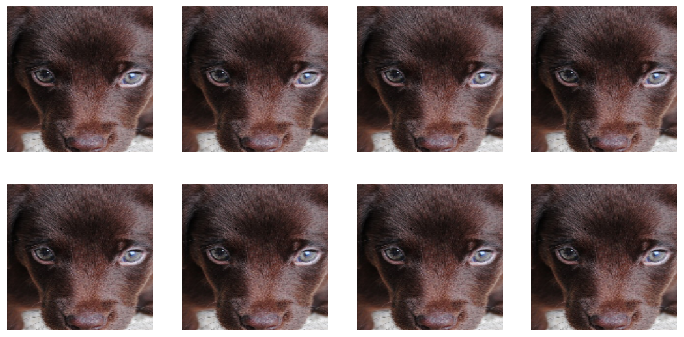

In [ ]:
t = _batch_ex(8)
rrc = RandomResizedCropGPU(224, p=1.)
y = rrc(t)
_,axs = plt.subplots(2,4, figsize=(12,6))
for ax in axs.flatten():
    show_image(y[i], ctx=ax)

### Flip/Dihedral GPU helpers

In [ ]:
# export
def affine_mat(*ms):
    "Restructure length-6 vector `ms` into an affine matrix with 0,0,1 in the last line"
    return stack([stack([ms[0], ms[1], ms[2]], dim=1),
                  stack([ms[3], ms[4], ms[5]], dim=1),
                  stack([t0(ms[0]), t0(ms[0]), t1(ms[0])], dim=1)], dim=1)

In [ ]:
# export
def mask_tensor(x, p=0.5, neutral=0., batch=False):
    "Mask elements of `x` with `neutral` with probability `1-p`"
    if p==1.: return x
    if batch: return x if random.random() < p else x.new_zeros(*x.size()) + neutral
    if neutral != 0: x.add_(-neutral)
    mask = x.new_empty(*x.size()).bernoulli_(p)
    x.mul_(mask)
    return x.add_(neutral) if neutral != 0 else x

In [ ]:
# export
def _draw_mask(x, def_draw, draw=None, p=0.5, neutral=0., batch=False):
    if draw is None: draw=def_draw
    if callable(draw): res=draw(x)
    elif is_listy(draw):
        test_eq(len(draw), x.size(0))
        res = tensor(draw, dtype=x.dtype, device=x.device)
    else: res = x.new_zeros(x.size(0)) + draw
    return mask_tensor(res, p=p, neutral=neutral, batch=batch)

In [ ]:
x = torch.zeros(5,2,3)
def_draw = lambda x: torch.randint(0,8, (x.size(0),))
t = _draw_mask(x, def_draw)
assert (0. <= t).all() and (t <= 7).all() 
t = _draw_mask(x, def_draw, 1)
assert (0. <= t).all() and (t <= 1).all() 
test_eq(_draw_mask(x, def_draw, 1, p=1), tensor([1.,1,1,1,1]))
test_eq(_draw_mask(x, def_draw, [0,1,2,3,4], p=1), tensor([0.,1,2,3,4]))
for i in range(5):
    t = _draw_mask(x, def_draw, 1, batch=True)
    assert (t==torch.zeros(5)).all() or (t==torch.ones(5)).all()

In [ ]:
# export
def flip_mat(x, p=0.5, draw=None, batch=False):
    "Return a random flip matrix"
    def _def_draw(x): return x.new_ones(x.size(0))
    mask = x.new_ones(x.size(0)) - 2*_draw_mask(x, _def_draw, draw=draw, p=p, batch=batch)
    #mask = mask_tensor(-x.new_ones(x.size(0)), p=p, neutral=1.)
    return affine_mat(mask,     t0(mask), t0(mask),
                      t0(mask), t1(mask), t0(mask))

In [ ]:
x = flip_mat(torch.randn(100,4,3))
test_eq(set(x[:,0,0].numpy()), {-1,1}) #might fail with probability 2*2**(-100) (picked only 1s or -1s)

In [ ]:
#export
def _get_default(x, mode=None, pad_mode=None):
    if mode is None: mode='bilinear' if isinstance(x, TensorMask) else 'bilinear'
    if pad_mode is None: pad_mode=PadMode.Zeros if isinstance(x, (TensorPoint, TensorBBox)) else PadMode.Reflection
    x0 = x[0] if isinstance(x, tuple) else x
    return x0,mode,pad_mode

### Flip -

In [ ]:
# export
@patch
def flip_batch(x: (TensorImage,TensorMask,TensorPoint,TensorBBox), p=0.5, draw=None, size=None,
               mode=None, pad_mode=None, batch=False):
    x0,mode,pad_mode = _get_default(x, mode, pad_mode)
    mat=flip_mat(x0, p=p, draw=draw, batch=batch)
    return x.affine_coord(mat=mat[:,:2], sz=size, mode=mode, pad_mode=pad_mode)

In [ ]:
t = _pnt2tensor([[1,0], [2,1]], (3,3))
y = TensorImage(t[None,None]).flip_batch(p=1.)
test_eq(y, _pnt2tensor([[1,0], [0,1]], (3,3))[None,None])

pnts = TensorPoint((tensor([[1.,0.], [2,1]]) -1)[None])
test_eq(pnts.flip_batch(p=1.), tensor([[[1.,0.], [0,1]]]) -1)

bbox = TensorBBox(((tensor([[1.,0., 2.,1]]) -1)[None]))
test_eq(bbox.flip_batch(p=1.), tensor([[[0.,0., 1.,1.]]]) -1)

In [ ]:
# export
def Flip(p=0.5, draw=None, size=None, mode='bilinear', pad_mode=PadMode.Reflection, batch=False):
    "Randomly flip a batch of images with a probability `p`"
    return AffineCoordTfm(aff_fs=partial(flip_mat, p=p, draw=draw, batch=batch), size=size, mode=mode, pad_mode=pad_mode)

In [ ]:
flip = Flip(p=1.)
t = _pnt2tensor([[1,0], [2,1]], (3,3))
y = flip(TensorImage(t[None,None]), split_idx=0)
test_eq(y, _pnt2tensor([[1,0], [0,1]], (3,3))[None,None])

pnts = TensorPoint((tensor([[1.,0.], [2,1]]) -1)[None])
test_eq(flip(pnts, split_idx=0), tensor([[[1.,0.], [0,1]]]) -1)

bbox = TensorBBox(((tensor([[1.,0., 2.,1]]) -1)[None]))
test_eq(flip(bbox, split_idx=0), tensor([[[0.,0., 1.,1.]]]) -1)

In [ ]:
# export
class DeterministicDraw():
    def __init__(self, vals):
        store_attr(self, 'vals')
        self.count=-1

    def __call__(self, x):
        self.count += 1
        return x.new_zeros(x.size(0)) + self.vals[self.count%len(self.vals)]

In [ ]:
t =  _batch_ex(8)
draw = DeterministicDraw(list(range(8)))
for i in range(15): test_eq(draw(t), torch.zeros(8)+(i%8))

In [ ]:
# export
def DeterministicFlip(size=None, mode='bilinear', pad_mode=PadMode.Reflection):
    "Flip the batch every other call"
    return Flip(p=1., draw=DeterministicDraw([0,1]))

In [ ]:
t = _batch_ex(8)
dih = DeterministicFlip()
_,axs = plt.subplots(2,4, figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
    y = dih(t)
    show_image(y[0], ctx=ax, title=f'Call {i}')

### Dihedral -

In [ ]:
# export
def dihedral_mat(x, p=0.5, draw=None, batch=False):
    "Return a random dihedral matrix"
    def _def_draw(x):   return torch.randint(0,8, (x.size(0),), device=x.device)
    def _def_draw_b(x): return random.randint(0,7) + x.new_zeros((x.size(0),)).long()
    idx = _draw_mask(x, _def_draw_b if batch else _def_draw, draw=draw, p=p, batch=batch).long()
    xs = tensor([1,-1,1,-1,-1,1,1,-1], device=x.device).gather(0, idx)
    ys = tensor([1,1,-1,1,-1,-1,1,-1], device=x.device).gather(0, idx)
    m0 = tensor([1,1,1,0,1,0,0,0], device=x.device).gather(0, idx)
    m1 = tensor([0,0,0,1,0,1,1,1], device=x.device).gather(0, idx)
    return affine_mat(xs*m0,  xs*m1,  t0(xs),
                      ys*m1,  ys*m0,  t0(xs)).float()

In [ ]:
# export
@patch
def dihedral_batch(x: (TensorImage,TensorMask,TensorPoint,TensorBBox), p=0.5, draw=None, size=None,
                   mode=None, pad_mode=None, batch=False):
    x0,mode,pad_mode = _get_default(x, mode, pad_mode)
    mat = _prepare_mat(x, dihedral_mat(x0, p=p, draw=draw, batch=batch))
    return x.affine_coord(mat=mat, sz=size, mode=mode, pad_mode=pad_mode)

In [ ]:
# export
def Dihedral(p=0.5, draw=None, size=None, mode='bilinear', pad_mode=PadMode.Reflection, batch=False):
    "Apply a random dihedral transformation to a batch of images with a probability `p`"
    f = partial(dihedral_mat, p=p, draw=draw, batch=batch)
    return AffineCoordTfm(aff_fs=f, size=size, mode=mode, pad_mode=pad_mode)

`draw` can be specified if you want to customize which flip is picked when the transform is applied (default is a random number between 0 and 7). It can be an integer between 0 and 7, a list of such integers (which then should have a length equal to the size of the batch) or a callable that returns an integer between 0 and 7.

In [ ]:
t = _batch_ex(8)
dih = Dihedral(p=1., draw=list(range(8)))
y = dih(t)
y = t.dihedral_batch(p=1., draw=list(range(8)))
_,axs = plt.subplots(2,4, figsize=(12,5))
for i,ax in enumerate(axs.flatten()): show_image(y[i], ctx=ax, title=f'Flip {i}')

In [ ]:
#hide
#Test behavior with images and points is consistent
t = _pnt2tensor([[1,0], [2,1], [2,2]], (3,3))[None,None].expand(8,1,3,3)
dih = Dihedral(p=1., draw=list(range(8)))
dih.as_item=False
pnts = tensor([[[1.,0.], [2,1], [2,2]]]) -1
y,z = dih((TensorImage(t),TensorPoint(pnts.expand(8,3,2))), split_idx=0)
res = y.nonzero()
for i in range(8):
    vals = {(t[0] + t[1]*3).item() for t in res[i*3:(i+1)*3][:,2:].flip(1)}
    vals1 = {(t[0] + t[1]*3).item() for t in z[i]+1}
    test_eq(vals, vals1)
    
#Test order is the same as DihedralItem
tt = _pnt2tensor([[1,0], [2,1], [2,2]], (3,3))
x = PILImage.create(tt)
for i in range(8):
    y1 = x.dihedral(i)
    test_eq(y[i,0], tensor(array(y1)))

In [ ]:
# export
def DeterministicDihedral(size=None, mode='bilinear', pad_mode=PadMode.Reflection):
    "Flip the batch every other call"
    return Dihedral(p=1., draw=DeterministicDraw(list(range(8))))

In [ ]:
t = _batch_ex(8)
dih = DeterministicDihedral()
_,axs = plt.subplots(2,4, figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
    y = dih(t)
    show_image(y[0], ctx=ax, title=f'Call {i}')

### Rotate -

In [ ]:
# export
def rotate_mat(x, max_deg=10, p=0.5, draw=None, batch=False):
    "Return a random rotation matrix with `max_deg` and `p`"
    def _def_draw(x):   return x.new(x.size(0)).uniform_(-max_deg, max_deg)
    def _def_draw_b(x): return x.new_zeros(x.size(0)) + random.uniform(-max_deg, max_deg)
    thetas = _draw_mask(x, _def_draw_b if batch else _def_draw, draw=draw, p=p, batch=batch) * math.pi/180
    return affine_mat(thetas.cos(), thetas.sin(), t0(thetas),
                     -thetas.sin(), thetas.cos(), t0(thetas))

In [ ]:
# export
@delegates(rotate_mat)
@patch
def rotate(x: (TensorImage,TensorMask,TensorPoint,TensorBBox), size=None, mode=None, pad_mode=None, **kwargs):
    x0,mode,pad_mode = _get_default(x, mode, pad_mode)
    mat = _prepare_mat(x, rotate_mat(x0, **kwargs))
    return x.affine_coord(mat=mat, sz=size, mode=mode, pad_mode=pad_mode)

In [ ]:
# export
def Rotate(max_deg=10, p=0.5, draw=None, size=None, mode='bilinear', pad_mode=PadMode.Reflection, batch=False):
    "Apply a random rotation of at most `max_deg` with probability `p` to a batch of images"
    return AffineCoordTfm(partial(rotate_mat, max_deg=max_deg, p=p, draw=draw, batch=batch),
                          size=size, mode=mode, pad_mode=pad_mode)

`draw` can be specified if you want to customize which angle is picked when the transform is applied (default is a random flaot between `-max_deg` and `max_deg`). It can be a float, a list of floats (which then should have a length equal to the size of the batch) or a callable that returns a float.

In [ ]:
thetas = [-30,-15,0,15,30]
y = _batch_ex(5).rotate(draw=thetas, p=1.)
_,axs = plt.subplots(1,5, figsize=(15,3))
for i,ax in enumerate(axs.flatten()):
    show_image(y[i], ctx=ax, title=f'{thetas[i]} degrees')

### Zoom -

In [ ]:
# export
def zoom_mat(x, max_zoom=1.1, p=0.5, draw=None, draw_x=None, draw_y=None, batch=False):
    "Return a random zoom matrix with `max_zoom` and `p`"
    def _def_draw(x):       return x.new(x.size(0)).uniform_(1, max_zoom)
    def _def_draw_b(x):     return x.new_zeros(x.size(0)) + random.uniform(1, max_zoom)
    def _def_draw_ctr(x):   return x.new(x.size(0)).uniform_(0,1)
    def _def_draw_ctr_b(x): return x.new_zeros(x.size(0)) + random.uniform(0,1)
    s = 1/_draw_mask(x, _def_draw_b if batch else _def_draw, draw=draw, p=p, neutral=1., batch=batch)
    def_draw_c = _def_draw_ctr_b if batch else _def_draw_ctr
    col_pct = _draw_mask(x, def_draw_c, draw=draw_x, p=1., batch=batch)
    row_pct = _draw_mask(x, def_draw_c, draw=draw_y, p=1., batch=batch)
    col_c = (1-s) * (2*col_pct - 1)
    row_c = (1-s) * (2*row_pct - 1)
    return affine_mat(s,     t0(s), col_c,
                      t0(s), s,     row_c)

In [ ]:
# export
@delegates(zoom_mat)
@patch
def zoom(x: (TensorImage,TensorMask,TensorPoint,TensorBBox), size=None, mode='bilinear', pad_mode=PadMode.Reflection, **kwargs):
    x0,mode,pad_mode = _get_default(x, mode, pad_mode)
    return x.affine_coord(mat=zoom_mat(x0, **kwargs)[:,:2], sz=size, mode=mode, pad_mode=pad_mode)

In [ ]:
# export
def Zoom(max_zoom=1.1, p=0.5, draw=None, draw_x=None, draw_y=None, size=None, mode='bilinear',
         pad_mode=PadMode.Reflection, batch=False):
    "Apply a random zoom of at most `max_zoom` with probability `p` to a batch of images"
    return AffineCoordTfm(partial(zoom_mat, max_zoom=max_zoom, p=p, draw=draw, draw_x=draw_x, draw_y=draw_y, batch=batch),
                          size=size, mode=mode, pad_mode=pad_mode)

`draw`, `draw_x` and `draw_y` can be specified if you want to customize which scale and center are picked when the transform is applied (default is a random float between 1 and `max_zoom` for the first, between 0 and 1 for the last two). Each can be a float, a list of floats (which then should have a length equal to the size of the batch) or a callbale that returns a float.

`draw_x` and `draw_y` are expected to be the position of the center in pct, 0 meaning the most left/top possible and 1 meaning the most right/bottom possible.

In [ ]:
scales = [1., 1.1, 1.25, 1.5]
y = _batch_ex(4).zoom(draw=scales, p=1., draw_x=0.5, draw_y=0.5)
fig,axs = plt.subplots(1,4, figsize=(12,3))
fig.suptitle('Center zoom with different scales')
for i,ax in enumerate(axs.flatten()):
    show_image(y[i], ctx=ax, title=f'scale {scales[i]}')

In [ ]:
y = _batch_ex(4).zoom(p=1., draw=1.5)
fig,axs = plt.subplots(1,4, figsize=(12,3))
fig.suptitle('Constant scale and different random centers')
for i,ax in enumerate(axs.flatten()):
    show_image(y[i], ctx=ax)

### Warping

In [ ]:
# export
def find_coeffs(p1, p2):
    "Find coefficients for warp tfm from `p1` to `p2`"
    m = []
    p = p1[:,0,0]
    #The equations we'll need to solve.
    for i in range(p1.shape[1]):
        m.append(stack([p2[:,i,0], p2[:,i,1], t1(p), t0(p), t0(p), t0(p), -p1[:,i,0]*p2[:,i,0], -p1[:,i,0]*p2[:,i,1]]))
        m.append(stack([t0(p), t0(p), t0(p), p2[:,i,0], p2[:,i,1], t1(p), -p1[:,i,1]*p2[:,i,0], -p1[:,i,1]*p2[:,i,1]]))
    #The 8 scalars we seek are solution of AX = B
    A = stack(m).permute(2, 0, 1)
    B = p1.view(p1.shape[0], 8, 1)
    return torch.solve(B,A)[0]

In [ ]:
# export
def apply_perspective(coords, coeffs):
    "Apply perspective tranfom on `coords` with `coeffs`"
    sz = coords.shape
    coords = coords.view(sz[0], -1, 2)
    coeffs = torch.cat([coeffs, t1(coeffs[:,:1])], dim=1).view(coeffs.shape[0], 3,3)
    coords = coords @ coeffs[...,:2].transpose(1,2) + coeffs[...,2].unsqueeze(1)
    coords = coords/coords[...,2].unsqueeze(-1)
    return coords[...,:2].view(*sz)

In [ ]:
# export
class _WarpCoord():
    def __init__(self, magnitude=0.2, p=0.5, draw_x=None, draw_y=None, batch=False):
        store_attr(self, "magnitude,p,draw_x,draw_y,batch")
        self.coeffs = None

    def _def_draw(self, x):
        if not self.batch: return x.new(x.size(0)).uniform_(-self.magnitude, self.magnitude)
        return x.new_zeros(x.size(0)) + random.uniform(-self.magnitude, self.magnitude)

    def before_call(self, x):
        x_t = _draw_mask(x, self._def_draw, self.draw_x, p=self.p, batch=self.batch)
        y_t = _draw_mask(x, self._def_draw, self.draw_y, p=self.p, batch=self.batch)
        orig_pts = torch.tensor([[-1,-1], [-1,1], [1,-1], [1,1]], dtype=x.dtype, device=x.device)
        self.orig_pts = orig_pts.unsqueeze(0).expand(x.size(0),4,2)
        targ_pts = stack([stack([-1-y_t, -1-x_t]), stack([-1+y_t, 1+x_t]),
                          stack([ 1+y_t, -1+x_t]), stack([ 1-y_t, 1-x_t])])
        self.targ_pts = targ_pts.permute(2,0,1)

    def __call__(self, x, invert=False):
        coeffs = find_coeffs(self.targ_pts, self.orig_pts) if invert else find_coeffs(self.orig_pts, self.targ_pts)
        return apply_perspective(x, coeffs)

In [ ]:
# export
@delegates(_WarpCoord.__init__)
@patch
def warp(x:(TensorImage,TensorMask,TensorPoint,TensorBBox), size=None, mode='bilinear',
         pad_mode=PadMode.Reflection, **kwargs):
    x0,mode,pad_mode = _get_default(x, mode, pad_mode)
    coord_tfm = _WarpCoord(**kwargs)
    coord_tfm.before_call(x0)
    return x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)

In [ ]:
#hide
x1 = tensor([[1.,0.,0.,0.,1.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.]])
x2 = tensor([[0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [1.,0.,0.,0.,1.]])
x3 = tensor([[1.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [1.,0.,0.,0.,0.]])
x4 = tensor([[0.,0.,0.,0.,1.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,1.]])
y = TensorImage(stack([x1,x2,x3,x4])[:,None])
y = y.warp(p=1., draw_x=[0.,0,-0.5,0.5], draw_y=[-0.5,0.5,0.,0.])
test_eq(y[0,0], tensor([[0.,1.,0.,1.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.]]))
test_eq(y[1,0], tensor([[0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,1.,0.,1.,0.]]))
test_eq(y[2,0], tensor([[0.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [0.,0.,0.,0.,0.]]))
test_eq(y[3,0], tensor([[0.,0.,0.,0.,0.], [0.,0.,0.,0.,1.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,1.], [0.,0.,0.,0.,0.]]))

In [ ]:
#hide
x = torch.tensor([[[-1.,-1], [1,-1]], [[-1,1],[1,1]], [[-1,-1], [-1,1]], [[1,-1], [1,1]]])
y = TensorPoint(x).warp(p=1., draw_x=[0.,0,-0.5,0.5], draw_y=[-0.5,0.5,0.,0.])
test_eq(y, torch.tensor([[[-0.5,-1], [0.5,-1]], [[-0.5,1],[0.5,1]], [[-1,-0.5], [-1,0.5]], [[1,-0.5], [1,0.5]]]))

In [ ]:
# export
def Warp(magnitude=0.2, p=0.5, draw_x=None, draw_y=None,size=None, mode='bilinear',
         pad_mode=PadMode.Reflection, batch=False):
    "Apply perspective warping with `magnitude` and `p` on a batch of matrices"
    return AffineCoordTfm(coord_fs=_WarpCoord(magnitude=magnitude, p=p, draw_x=draw_x, draw_y=draw_y, batch=batch),
                          size=size, mode=mode, pad_mode=pad_mode)

`draw_x` and `draw_y` can be specified if you want to customize the magnitudes that are picked when the transform is applied (default is a random float between `-magnitude` and `magnitude`. Each can be a float, a list of floats (which then should have a length equal to the size of the batch) or a callable that returns a float.

In [ ]:
scales = [-0.4, -0.2, 0., 0.2, 0.4]
warp = Warp(p=1., draw_y=scales, draw_x=0.)
y = warp(_batch_ex(5), split_idx=0)
fig,axs = plt.subplots(1,5, figsize=(15,3))
fig.suptitle('Vertical warping')
for i,ax in enumerate(axs.flatten()):
    show_image(y[i], ctx=ax, title=f'magnitude {scales[i]}')

In [ ]:
scales = [-0.4, -0.2, 0., 0.2, 0.4]
warp = Warp(p=1., draw_x=scales, draw_y=0.)
y = warp(_batch_ex(5), split_idx=0)
fig,axs = plt.subplots(1,5, figsize=(15,3))
fig.suptitle('Horizontal warping')
for i,ax in enumerate(axs.flatten()):
    show_image(y[i], ctx=ax, title=f'magnitude {scales[i]}')

In [ ]:
#hide
x1 = tensor([[1.,0.,0.,0.,1.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.]])
x2 = tensor([[0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [1.,0.,0.,0.,1.]])
x3 = tensor([[1.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [1.,0.,0.,0.,0.]])
x4 = tensor([[0.,0.,0.,0.,1.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,1.]])
warp = Warp(p=1., draw_x=[0.,0,-0.5,0.5], draw_y=[-0.5,0.5,0.,0.])
y = warp(TensorImage(stack([x1,x2,x3,x4])[:,None]), split_idx=0)
test_eq(y[0,0], tensor([[0.,1.,0.,1.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.]]))
test_eq(y[1,0], tensor([[0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,1.,0.,1.,0.]]))
test_eq(y[2,0], tensor([[0.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [0.,0.,0.,0.,0.]]))
test_eq(y[3,0], tensor([[0.,0.,0.,0.,0.], [0.,0.,0.,0.,1.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,1.], [0.,0.,0.,0.,0.]]))

In [ ]:
#hide
x = torch.tensor([[[-1.,-1], [1,-1]], [[-1,1],[1,1]], [[-1,-1], [-1,1]], [[1,-1], [1,1]]])
y = warp(TensorPoint(x), split_idx=0)
test_eq(y, torch.tensor([[[-0.5,-1], [0.5,-1]], [[-0.5,1],[0.5,1]], [[-1,-0.5], [-1,0.5]], [[1,-0.5], [1,0.5]]]))

## Lighting transforms

In [ ]:
# export
@patch
def lighting(x: TensorImage, func):
    return TensorImage(torch.sigmoid(func(logit(x))))

In [ ]:
# export
class LightingTfm(RandTransform):
    "Apply `fs` to the logits"
    order = 40
    def __init__(self, fs): self.fs=L(fs)
    def before_call(self, b, split_idx):
        self.do = True
        if isinstance(b, tuple): b = b[0]
        for t in self.fs: t.before_call(b)

    def compose(self, tfm):
        "Compose `self` with another `LightingTransform`"
        self.fs += tfm.fs

    def encodes(self,x:TensorImage): return x.lighting(partial(compose_tfms, tfms=self.fs))

In [ ]:
# export
class _BrightnessLogit():
    def __init__(self, max_lighting=0.2, p=0.75, draw=None, batch=False):
        store_attr(self, 'max_lighting,p,draw,batch')

    def _def_draw(self, x):
        if not self.batch: return x.new(x.size(0)).uniform_(0.5*(1-self.max_lighting), 0.5*(1+self.max_lighting))
        return x.new_zeros(x.size(0)) + random.uniform(0.5*(1-self.max_lighting), 0.5*(1+self.max_lighting))

    def before_call(self, x):
        self.change = _draw_mask(x, self._def_draw, draw=self.draw, p=self.p, neutral=0.5, batch=self.batch)

    def __call__(self, x): return x.add_(logit(self.change[:,None,None,None]))

In [ ]:
# export
@delegates(_BrightnessLogit.__init__)
@patch
def brightness(x: TensorImage, **kwargs):
    func = _BrightnessLogit(**kwargs)
    func.before_call(x)
    return x.lighting(func)

In [ ]:
# export
def Brightness(max_lighting=0.2, p=0.75, draw=None, batch=False):
    "Apply change in brightness of `max_lighting` to batch of images with probability `p`."
    return LightingTfm(_BrightnessLogit(max_lighting, p, draw, batch))

`draw` can be specified if you want to customize the magnitude that is picked when the transform is applied (default is a random float between `-0.5*(1-max_lighting)` and `0.5*(1+max_lighting)`. Each can be a float, a list of floats (which then should have a length equal to the size of the batch) or a callable that returns a float.

In [ ]:
scales = [0.1, 0.3, 0.5, 0.7, 0.9]
y = _batch_ex(5).brightness(draw=scales, p=1.)
fig,axs = plt.subplots(1,5, figsize=(15,3))
for i,ax in enumerate(axs.flatten()):
    show_image(y[i], ctx=ax, title=f'scale {scales[i]}')

In [ ]:
#hide
x = torch.randn(5, 3, 4, 4)
bright = Brightness(draw=scales, p=1.)
y = bright(TensorImage(x), split_idx=0)
y1 = torch.sigmoid(logit(x) + logit(tensor(scales))[:,None,None,None])
test_close(y, y1)

test_eq(bright(TensorMask(x), split_idx=0), x)
test_eq(bright(TensorPoint(x), split_idx=0), x)
test_eq(bright(TensorBBox(x), split_idx=0), x)

In [ ]:
# export
class _ContrastLogit():
    def __init__(self, max_lighting=0.2, p=0.75, draw=None, batch=False):
        store_attr(self, 'max_lighting,p,draw,batch')

    def _def_draw(self, x):
        if not self.batch: res = x.new(x.size(0)).uniform_(math.log(1-self.max_lighting), -math.log(1-self.max_lighting))
        else: res = x.new_zeros(x.size(0)) + random.uniform(math.log(1-self.max_lighting), -math.log(1-self.max_lighting))
        return torch.exp(res)

    def before_call(self, x):
        self.change = _draw_mask(x, self._def_draw, draw=self.draw, p=self.p, neutral=1., batch=self.batch)

    def __call__(self, x): return x.mul_(self.change[:,None,None,None])

In [ ]:
# export
@delegates(_ContrastLogit.__init__)
@patch
def contrast(x: TensorImage, **kwargs):
    func = _ContrastLogit(**kwargs)
    func.before_call(x)
    return x.lighting(func)

In [ ]:
# export
def Contrast(max_lighting=0.2, p=0.75, draw=None, batch=False):
    "Apply change in contrast of `max_lighting` to batch of images with probability `p`."
    return LightingTfm(_ContrastLogit(max_lighting, p, draw, batch))

`draw` can be specified if you want to customize the magnitude that is picked when the transform is applied (default is a random float taken with the log uniform distribution between `(1-max_lighting)` and `1/(1-max_lighting)`. Each can be a float, a list of floats (which then should have a length equal to the size of the batch) or a callable that returns a float.

In [ ]:
scales = [0.65, 0.8, 1., 1.25, 1.55]
y = _batch_ex(5).contrast(p=1., draw=scales)
fig,axs = plt.subplots(1,5, figsize=(15,3))
for i,ax in enumerate(axs.flatten()): show_image(y[i], ctx=ax, title=f'scale {scales[i]}')

In [ ]:
#hide
x = torch.randn(5, 3, 4, 4)
cont = Contrast(p=1., draw=scales)
y = cont(TensorImage(x), split_idx=0)
y1 = torch.sigmoid(logit(x) * tensor(scales)[:,None,None,None])
test_close(y, y1)

test_eq(cont(TensorMask(x), split_idx=0), x)
test_eq(cont(TensorPoint(x), split_idx=0), x)
test_eq(cont(TensorBBox(x), split_idx=0), x)

## RandomErasing

[Random Erasing Data Augmentation](https://arxiv.org/pdf/1708.04896.pdf). This variant, designed by Ross Wightman, is applied to either a batch or single image tensor after it has been normalized.

In [ ]:
#export
def cutout_gaussian(x, areas):
    "Replace all `areas` in `x` with N(0,1) noise"
    chan,img_h,img_w = x.shape[-3:]
    for rl,rh,cl,ch in areas: x[..., rl:rh, cl:ch].normal_()
    return x

Since this should be applied after normalization, we'll define a helper to apply a function inside normalization.

In [ ]:
#export
def norm_apply_denorm(x, f, nrm):
    "Normalize `x` with `nrm`, then apply `f`, then denormalize"
    y = f(nrm(x.clone()))
    return nrm.decode(y).clamp(0,1)

In [ ]:
nrm = Normalize.from_stats(*imagenet_stats, cuda=False)

In [ ]:
f = partial(cutout_gaussian, areas=[(100,200,100,200),(200,300,200,300)])
show_image(norm_apply_denorm(timg, f, nrm)[0]);

In [ ]:
#export
def _slice(area, sz):
    bound = int(round(math.sqrt(area)))
    loc = random.randint(0, max(sz-bound, 0))
    return loc,loc+bound

In [ ]:
# export
class RandomErasing(RandTransform):
    "Randomly selects a rectangle region in an image and randomizes its pixels."
    order = 100 # After Normalize
    def __init__(self, p=0.5, sl=0., sh=0.3, min_aspect=0.3, max_count=1):
        super().__init__(p=p)
        log_ratio = (math.log(min_aspect), math.log(1/min_aspect))
        store_attr(self, 'sl,sh,log_ratio,max_count')

    def _bounds(self, area, img_h, img_w):
        r_area = random.uniform(self.sl,self.sh) * area
        aspect = math.exp(random.uniform(*self.log_ratio))
        return _slice(r_area*aspect, img_h) + _slice(r_area/aspect, img_w)

    def encodes(self,x:TensorImage):
        count = random.randint(1, self.max_count)
        _,img_h,img_w = x.shape[-3:]
        area = img_h*img_w/count
        areas = [self._bounds(area, img_h, img_w) for _ in range(count)]
        return cutout_gaussian(x, areas)

**Args:**

- p: The probability that the Random Erasing operation will be performed
- sl: Minimum proportion of erased area
- sh: Maximum proportion of erased area
- min_aspect: Minimum aspect ratio of erased area
- max_count: maximum number of erasing blocks per image, area per box is scaled by count

In [ ]:
tfm = RandomErasing(p=1., max_count=6)

_,axs = subplots(2,3, figsize=(12,6))
f = partial(tfm, split_idx=0)
for i,ax in enumerate(axs.flatten()): show_image(norm_apply_denorm(timg, f, nrm)[0], ctx=ax)

In [ ]:
y = _batch_ex(6)
_,axs = plt.subplots(2,3, figsize=(12,6))
y = norm_apply_denorm(y, f, nrm)
for i,ax in enumerate(axs.flatten()): show_image(y[i], ctx=ax)

In [ ]:
tfm = RandomErasing(p=1., max_count=6)

_,axs = subplots(2,3, figsize=(12,6))
f = partial(tfm, split_idx=1)
for i,ax in enumerate(axs.flatten()): show_image(norm_apply_denorm(timg, f, nrm)[0], ctx=ax)

## All together

In [ ]:
# export
def _compose_same_tfms(tfms):
    tfms = L(tfms)
    if len(tfms) == 0: return None
    res = tfms[0]
    for tfm in tfms[1:]: res.compose(tfm)
    return res

In [ ]:
# export
def setup_aug_tfms(tfms):
    "Go through `tfms` and combines together affine/coord or lighting transforms"
    aff_tfms = [tfm for tfm in tfms if isinstance(tfm, AffineCoordTfm)]
    lig_tfms = [tfm for tfm in tfms if isinstance(tfm, LightingTfm)]
    others = [tfm for tfm in tfms if tfm not in aff_tfms+lig_tfms]
    aff_tfm,lig_tfm =  _compose_same_tfms(aff_tfms),_compose_same_tfms(lig_tfms)
    res = [aff_tfm] if aff_tfm is not None else []
    if lig_tfm is not None: res.append(lig_tfm)
    return res + others

In [ ]:
#Affine only
tfms = [Rotate(draw=10., p=1), Zoom(draw=1.1, draw_x=0.5, draw_y=0.5, p=1.)]
comp = setup_aug_tfms([Rotate(draw=10., p=1), Zoom(draw=1.1, draw_x=0.5, draw_y=0.5, p=1.)])
test_eq(len(comp), 1)
x = torch.randn(4,3,5,5)
test_close(comp[0]._get_affine_mat(x)[...,:2],tfms[0]._get_affine_mat(x)[...,:2] @ tfms[1]._get_affine_mat(x)[...,:2])
#We can't test that the ouput of comp or the composition of tfms on x is the same cause it's not (1 interpol vs 2 sp)

In [ ]:
#Affine + lighting
tfms = [Rotate(), Zoom(), Warp(), Brightness(), Flip(), Contrast()]
comp = setup_aug_tfms(tfms)
test_eq(len(comp), 2)
test_eq(len(comp[0].aff_fs), 3)
test_eq(len(comp[0].coord_fs), 1)
test_eq(len(comp[1].fs), 2)

In [ ]:
#Affine + lighting + others
tfms = [Rotate(), Zoom(), Warp(), Brightness(), Flip(), Contrast()]
comp = setup_aug_tfms(tfms)
test_eq(len(comp), 2)
test_eq(len(comp[0].aff_fs), 3)
test_eq(len(comp[0].coord_fs), 1)
test_eq(len(comp[1].fs), 2)

In [ ]:
# export
def aug_transforms(mult=1.0, do_flip=True, flip_vert=False, max_rotate=10., max_zoom=1.1, max_lighting=0.2,
                   max_warp=0.2, p_affine=0.75, p_lighting=0.75, xtra_tfms=None,
                   size=None, mode='bilinear', pad_mode=PadMode.Reflection, batch=False, min_scale=1.):
    "Utility func to easily create a list of flip, rotate, zoom, warp, lighting transforms."
    res,tkw = [],dict(size=size if min_scale==1. else None, mode=mode, pad_mode=pad_mode, batch=batch)
    max_rotate,max_lighting,max_warp = array([max_rotate,max_lighting,max_warp])*mult
    if do_flip: res.append(Dihedral(p=0.5, **tkw) if flip_vert else Flip(p=0.5, **tkw))
    if max_warp:   res.append(Warp(magnitude=max_warp, p=p_affine, **tkw))
    if max_rotate: res.append(Rotate(max_deg=max_rotate, p=p_affine, **tkw))
    if max_zoom>1: res.append(Zoom(max_zoom=max_zoom, p=p_affine, **tkw))
    if max_lighting:
        res.append(Brightness(max_lighting=max_lighting, p=p_lighting, batch=batch))
        res.append(Contrast(max_lighting=max_lighting, p=p_lighting, batch=batch))
    if min_scale!=1.: xtra_tfms = RandomResizedCropGPU(size, min_scale=min_scale, ratio=(1,1)) + L(xtra_tfms) 
    return setup_aug_tfms(res + L(xtra_tfms))

Random flip (or dihedral if `flip_vert=True`) with `p=0.5` is added when `do_flip=True`. With `p_affine` we apply a random rotation of `max_rotate` degrees, a random zoom of `max_zoom` and a perspective warping of `max_warp`. With `p_lighting` we apply a change in brightness and contrast of `max_lighting`. Custon `xtra_tfms` can be added. `size`, `mode` and `pad_mode` will be used for the interpolation. `max_rotate,max_lighting,max_warp` are multiplied by `mult` so you can more easily increase or decrease augmentation with a single parameter.

In [ ]:
tfms = aug_transforms(pad_mode='zeros', mult=2, min_scale=0.5)
y = _batch_ex(9)
for t in tfms: y = t(y, split_idx=0)
_,axs = plt.subplots(1,3, figsize=(12,3))
for i,ax in enumerate(axs.flatten()): show_image(y[i], ctx=ax)

In [ ]:
tfms = aug_transforms(pad_mode='zeros', mult=2, batch=True)
y = _batch_ex(9)
for t in tfms: y = t(y, split_idx=0)
_,axs = plt.subplots(1,3, figsize=(12,3))
for i,ax in enumerate(axs.flatten()): show_image(y[i], ctx=ax)

## Integration tests

### Segmentation

In [ ]:
camvid = untar_data(URLs.CAMVID_TINY)
fns = get_image_files(camvid/'images')
cam_fn = fns[0]
mask_fn = camvid/'labels'/f'{cam_fn.stem}_P{cam_fn.suffix}'
def _cam_lbl(fn): return mask_fn

In [ ]:
cam_dsrc = Datasets([cam_fn]*10, [PILImage.create, [_cam_lbl, PILMask.create]])
cam_tdl = TfmdDL(cam_dsrc.train, after_item=ToTensor(),
                 after_batch=[IntToFloatTensor(), *aug_transforms()], bs=9)
cam_tdl.show_batch(max_n=9, vmin=1, vmax=30)

### Point targets

In [ ]:
mnist = untar_data(URLs.MNIST_TINY)
mnist_fn = 'images/mnist3.png'
pnts = np.array([[0,0], [0,35], [28,0], [28,35], [9, 17]])
def _pnt_lbl(fn)->None: return TensorPoint.create(pnts)

In [ ]:
pnt_dsrc = Datasets([mnist_fn]*10, [[PILImage.create, Resize((35,28))], _pnt_lbl])
pnt_tdl = TfmdDL(pnt_dsrc.train, after_item=[PointScaler(), ToTensor()],
                 after_batch=[IntToFloatTensor(), *aug_transforms(max_warp=0)], bs=9)
pnt_tdl.show_batch(max_n=9)

### Bounding boxes

In [ ]:
coco = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco/'train.json')
idx=2
coco_fn,bbox = coco/'train'/images[idx],lbl_bbox[idx]

def _coco_bb(x):  return TensorBBox.create(bbox[0])
def _coco_lbl(x): return bbox[1]

In [ ]:
coco_dsrc = Datasets([coco_fn]*10, [PILImage.create, [_coco_bb], [_coco_lbl, MultiCategorize(add_na=True)]], n_inp=1)
coco_tdl = TfmdDL(coco_dsrc, bs=9, after_item=[BBoxLabeler(), PointScaler(), ToTensor()],
                  after_batch=[IntToFloatTensor(), *aug_transforms()])

coco_tdl.show_batch(max_n=9)

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()